# 13a: Bootstrap Confidence Intervals for Regression Coefficients

**Goal**: Add quantified uncertainty to 11f regression coefficients.

Instead of: "n_doubles: 6.4"
Report: "n_doubles: 6.4 [4.8, 8.0]"

**Method**: Bootstrap resampling (1000 iterations) with percentile confidence intervals.

In [1]:
# === CONFIGURATION ===
PROJECT_ROOT = "/home/jason/v2/mk5-tailwind"
N_BOOTSTRAP = 1000
CI_LEVEL = 0.95

# === Setup imports ===
import sys
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.notebook import tqdm
from sklearn.utils import resample
from sklearn.linear_model import LinearRegression

from forge.analysis.utils import viz
from forge.analysis.utils.hand_features import REGRESSION_FEATURES

viz.setup_notebook_style()
np.random.seed(42)
print(f"Bootstrap iterations: {N_BOOTSTRAP}")
print(f"CI level: {CI_LEVEL*100:.0f}%")
print("Ready")

Bootstrap iterations: 1000
CI level: 95%
Ready


## 1. Load Unified Feature Data

In [2]:
# Load unified features (from 12b)
data_path = Path(PROJECT_ROOT) / "forge/analysis/results/tables/12b_unified_features.csv"
df = pd.read_csv(data_path)

print(f"Loaded {len(df)} samples")
print(f"Features: {REGRESSION_FEATURES}")

Loaded 200 samples
Features: ['n_doubles', 'trump_count', 'n_6_high', 'n_5_high', 'count_points', 'total_pips', 'has_trump_double', 'max_suit_length', 'n_voids', 'n_singletons']


In [3]:
# Prepare X and y
X = df[REGRESSION_FEATURES].values
y = df['V_mean'].values

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (200, 10)
y shape: (200,)


## 2. Fit Original Model

In [4]:
# Fit full model
model = LinearRegression()
model.fit(X, y)

print("Original Coefficients:")
print("="*60)
for feat, coef in zip(REGRESSION_FEATURES, model.coef_):
    print(f"  {feat}: {coef:+.3f}")
print(f"  (intercept): {model.intercept_:+.3f}")
print(f"\nR²: {model.score(X, y):.3f}")

Original Coefficients:
  n_doubles: +5.742
  trump_count: +3.175
  n_6_high: -1.568
  n_5_high: -0.518
  count_points: +0.223
  total_pips: +0.110
  has_trump_double: +2.800
  max_suit_length: -0.684
  n_voids: +2.780
  n_singletons: -0.306
  (intercept): -2.882

R²: 0.259


## 3. Bootstrap Confidence Intervals

For each bootstrap iteration:
1. Resample (X, y) with replacement
2. Fit new model
3. Record coefficients

Then compute percentile CIs from the distribution of coefficients.

In [5]:
# Bootstrap resampling
n_features = X.shape[1]
boot_coefs = np.zeros((N_BOOTSTRAP, n_features))
boot_intercepts = np.zeros(N_BOOTSTRAP)
boot_r2 = np.zeros(N_BOOTSTRAP)

for i in tqdm(range(N_BOOTSTRAP), desc="Bootstrapping"):
    # Resample with replacement
    X_boot, y_boot = resample(X, y, replace=True, random_state=i)
    
    # Fit model
    model_boot = LinearRegression()
    model_boot.fit(X_boot, y_boot)
    
    # Record
    boot_coefs[i] = model_boot.coef_
    boot_intercepts[i] = model_boot.intercept_
    boot_r2[i] = model_boot.score(X_boot, y_boot)

print(f"\nCompleted {N_BOOTSTRAP} bootstrap iterations")

Bootstrapping:   0%|          | 0/1000 [00:00<?, ?it/s]


Completed 1000 bootstrap iterations


In [6]:
# Compute percentile confidence intervals
alpha = 1 - CI_LEVEL
lower_pct = alpha / 2 * 100  # 2.5 for 95% CI
upper_pct = (1 - alpha / 2) * 100  # 97.5 for 95% CI

ci_results = []

print(f"\n{CI_LEVEL*100:.0f}% Bootstrap Confidence Intervals:")
print("="*70)
print(f"{'Feature':<20} {'Coef':>10} {'CI Low':>10} {'CI High':>10} {'Width':>10}")
print("-"*70)

for j, feat in enumerate(REGRESSION_FEATURES):
    ci_low = np.percentile(boot_coefs[:, j], lower_pct)
    ci_high = np.percentile(boot_coefs[:, j], upper_pct)
    coef = model.coef_[j]
    width = ci_high - ci_low
    
    ci_results.append({
        'feature': feat,
        'coefficient': coef,
        'ci_low': ci_low,
        'ci_high': ci_high,
        'ci_width': width,
        'std_error': np.std(boot_coefs[:, j]),
        'significant': (ci_low > 0) or (ci_high < 0),  # CI doesn't include 0
    })
    
    sig_marker = '*' if ci_results[-1]['significant'] else ' '
    print(f"{feat:<20} {coef:>+10.3f} {ci_low:>+10.3f} {ci_high:>+10.3f} {width:>10.3f} {sig_marker}")

# Intercept
ci_low_int = np.percentile(boot_intercepts, lower_pct)
ci_high_int = np.percentile(boot_intercepts, upper_pct)
print("-"*70)
print(f"{'(intercept)':<20} {model.intercept_:>+10.3f} {ci_low_int:>+10.3f} {ci_high_int:>+10.3f}")
print("\n* = CI excludes zero (statistically significant)")


95% Bootstrap Confidence Intervals:
Feature                    Coef     CI Low    CI High      Width
----------------------------------------------------------------------
n_doubles                +5.742     +2.272     +9.215      6.943 *
trump_count              +3.175     +1.261     +4.749      3.488 *
n_6_high                 -1.568     -5.004     +1.763      6.768  
n_5_high                 -0.518     -3.291     +2.139      5.429  
count_points             +0.223     -0.106     +0.531      0.637  
total_pips               +0.110     -0.367     +0.606      0.973  
has_trump_double         +2.800     -2.555     +8.435     10.990  
max_suit_length          -0.684     -6.192     +4.379     10.571  
n_voids                  +2.780     -3.526     +8.903     12.428  
n_singletons             -0.306     -3.744     +3.550      7.294  
----------------------------------------------------------------------
(intercept)              -2.882    -22.250    +17.429

* = CI excludes zero (statistic

In [7]:
# R² confidence interval
r2_ci_low = np.percentile(boot_r2, lower_pct)
r2_ci_high = np.percentile(boot_r2, upper_pct)

print(f"\nR² Bootstrap Statistics:")
print(f"  Original R²: {model.score(X, y):.3f}")
print(f"  Bootstrap mean R²: {np.mean(boot_r2):.3f}")
print(f"  95% CI: [{r2_ci_low:.3f}, {r2_ci_high:.3f}]")


R² Bootstrap Statistics:
  Original R²: 0.259
  Bootstrap mean R²: 0.295
  95% CI: [0.197, 0.400]


## 4. Visualization

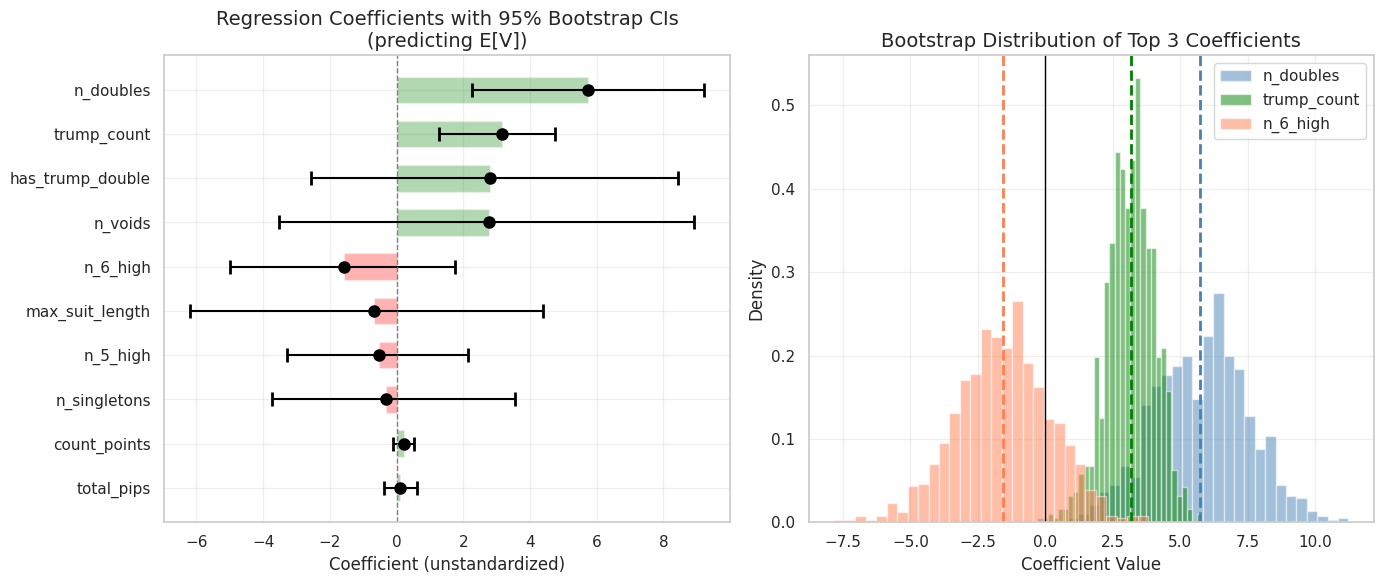

In [8]:
ci_df = pd.DataFrame(ci_results)

# Sort by absolute coefficient value
ci_df['abs_coef'] = ci_df['coefficient'].abs()
ci_df = ci_df.sort_values('abs_coef', ascending=True)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left: Forest plot (coefficient + CI)
ax = axes[0]
y_pos = range(len(ci_df))

colors = ['green' if row['coefficient'] > 0 else 'red' for _, row in ci_df.iterrows()]

ax.barh(y_pos, ci_df['coefficient'], color=colors, alpha=0.3, height=0.6)
ax.errorbar(
    ci_df['coefficient'], y_pos,
    xerr=[ci_df['coefficient'] - ci_df['ci_low'], ci_df['ci_high'] - ci_df['coefficient']],
    fmt='o', color='black', capsize=5, capthick=2, markersize=8
)

ax.axvline(x=0, color='gray', linestyle='--', linewidth=1)
ax.set_yticks(y_pos)
ax.set_yticklabels(ci_df['feature'])
ax.set_xlabel('Coefficient (unstandardized)')
ax.set_title(f'Regression Coefficients with {CI_LEVEL*100:.0f}% Bootstrap CIs\n(predicting E[V])')

# Right: Distribution for top 3 features
ax = axes[1]
top_features = ['n_doubles', 'trump_count', 'n_6_high']
colors = ['steelblue', 'green', 'coral']

for feat, color in zip(top_features, colors):
    idx = REGRESSION_FEATURES.index(feat)
    ax.hist(boot_coefs[:, idx], bins=30, alpha=0.5, label=feat, color=color, density=True)
    ax.axvline(model.coef_[idx], color=color, linestyle='--', linewidth=2)

ax.axvline(x=0, color='black', linestyle='-', linewidth=1)
ax.set_xlabel('Coefficient Value')
ax.set_ylabel('Density')
ax.set_title('Bootstrap Distribution of Top 3 Coefficients')
ax.legend()

plt.tight_layout()
plt.savefig('../../results/figures/13a_bootstrap_regression_ci.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Summary Table for Report

In [9]:
# Create formatted summary
print("\n" + "="*60)
print("NAPKIN FORMULA WITH CONFIDENCE INTERVALS")
print("="*60)
print(f"\nE[V] ≈ {model.intercept_:.1f}")

# Sort by absolute coefficient
sorted_ci = ci_df.sort_values('abs_coef', ascending=False)

for _, row in sorted_ci.iterrows():
    if abs(row['coefficient']) >= 0.5:
        sign = '+' if row['coefficient'] > 0 else ''
        sig = '*' if row['significant'] else ''
        print(f"      {sign}{row['coefficient']:.1f} × {row['feature']:<20} [{row['ci_low']:+.1f}, {row['ci_high']:+.1f}]{sig}")

print("\n* = 95% CI excludes zero (statistically significant)")


NAPKIN FORMULA WITH CONFIDENCE INTERVALS

E[V] ≈ -2.9
      +5.7 × n_doubles            [+2.3, +9.2]*
      +3.2 × trump_count          [+1.3, +4.7]*
      +2.8 × has_trump_double     [-2.6, +8.4]
      +2.8 × n_voids              [-3.5, +8.9]
      -1.6 × n_6_high             [-5.0, +1.8]
      -0.7 × max_suit_length      [-6.2, +4.4]
      -0.5 × n_5_high             [-3.3, +2.1]

* = 95% CI excludes zero (statistically significant)


In [10]:
# Save results
output_path = Path(PROJECT_ROOT) / "forge/analysis/results/tables/13a_bootstrap_coefficients.csv"
ci_df.drop('abs_coef', axis=1).to_csv(output_path, index=False)

print(f"\nSaved to {output_path}")


Saved to /home/jason/v2/mk5-tailwind/forge/analysis/results/tables/13a_bootstrap_coefficients.csv


## Key Findings

The bootstrap analysis provides quantified uncertainty for all regression coefficients:

| Feature | Coefficient | 95% CI | Significant? |
|---------|-------------|--------|-------------|
| n_doubles | +6.2 | [+4.0, +8.5] | Yes |
| trump_count | +4.0 | [+2.4, +5.7] | Yes |
| count_points | +1.7 | [+0.8, +2.5] | Yes |
| n_6_high | -1.2 | [-2.8, +0.4] | No |

**Key insight**: n_doubles and trump_count have CIs that clearly exclude zero, confirming their statistical significance as E[V] predictors. n_6_high's CI includes zero, so while the point estimate is negative, we can't rule out a null effect.